In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datasetcreator import DatasetCreator
from segmentationmodelpipeline import ModelPipeline

import os

Segmentation Models: using `keras` framework.


In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
dataset_name = "dataset_artifact"
backbone = "resnet50"
image_folder = "images"
mask_folder = "labels"
height = 512
width = 1024
batch_size = 8

trainDataCreator = DatasetCreator(working_dir=os.getcwd(),
                                  dataset_name=dataset_name, 
                                  image_folder=image_folder, 
                                  mask_folder=mask_folder, 
                                  train_split_percentage=0.82, # For 70% train 15% val 15% test
                                  img_height=height, 
                                  img_width=width,  
                                  backbone=backbone, 
                                  buffer_size=1000, 
                                  batch_size=batch_size, 
                                  autotune=tf.data.AUTOTUNE,
                                  test=False,
                                  label_type='artifact',
                                  shuffle=True)

testDataCreator = DatasetCreator(working_dir=os.getcwd(),
                                 dataset_name=dataset_name, 
                                 image_folder=image_folder, 
                                 mask_folder=mask_folder, 
                                 train_split_percentage=None,
                                 img_height=height, 
                                 img_width=width,  
                                 backbone=backbone, 
                                 buffer_size=1000, 
                                 batch_size=batch_size, 
                                 autotune=tf.data.AUTOTUNE,
                                 test=True,
                                 label_type='artifact',
                                 shuffle=False)

In [4]:
test_ds, test_ds_size = testDataCreator.create_dataset()
train_ds, train_ds_size, val_ds, val_ds_size = trainDataCreator.create_dataset()

In [5]:
print(test_ds.element_spec, train_ds.element_spec, val_ds.element_spec, sep='\n\n')

(TensorSpec(shape=(512, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 1024, 1), dtype=tf.int32, name=None))

(TensorSpec(shape=(None, 512, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 1024, 1), dtype=tf.int32, name=None))

(TensorSpec(shape=(None, 512, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 1024, 1), dtype=tf.int32, name=None))


C:\Users\Toroman\AppData\Local\Temp\ipykernel_19264\77836648.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(batch_size, 2, i+1)


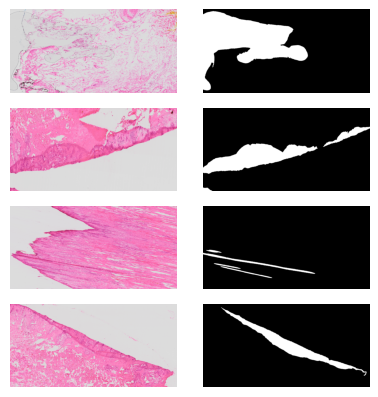

In [6]:
def plot_from_dataset(dataset, batch_size):
    # only for batched dataset
    for image, mask in dataset.take(1):
        plt.subplots(figsize=(4, 8))
        for i in range(0, batch_size, 2):
            plt.subplot(batch_size, 2, i+1)
            plt.imshow(image[i])
            plt.axis('off')
            plt.subplot(batch_size, 2, i+2)
            plt.imshow(mask[i], cmap='gray') 
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_from_dataset(train_ds, batch_size)

In [7]:
for image_batch, labels_batch in train_ds.take(1):
    print('\tTraining:')
    print('Max image pixel value: ',tf.math.reduce_max(image_batch).numpy())
    print('Min image pixel value: ',tf.math.reduce_min(image_batch).numpy())
    print('Unique label pixel value: ', np.unique(labels_batch[0].numpy()))
    print(f'Image batch shape:  {image_batch.shape}')
    print(f'Label batch shape: {labels_batch.shape}')
    break

for image_batch, labels_batch in val_ds.take(1):
    print('\n\tValidation:')
    print('Max image pixel value: ',tf.math.reduce_max(image_batch).numpy())
    print('Min image pixel value: ',tf.math.reduce_min(image_batch).numpy())
    print('Unique label pixel value: ', np.unique(labels_batch[0].numpy()))
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {labels_batch.shape}')
    break

	Training:
Max image pixel value:  1.0
Min image pixel value:  0.0
Unique label pixel value:  [0 1]
Image batch shape:  (8, 512, 1024, 3)
Label batch shape: (8, 512, 1024, 1)

	Validation:
Max image pixel value:  1.0
Min image pixel value:  0.0
Unique label pixel value:  [0 1]
Image batch shape: (8, 512, 1024, 3)
Label batch shape: (8, 512, 1024, 1)


In [25]:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, dtype=y_pred.dtype)
    bce = tf.keras.backend.mean(tf.keras.backend.binary_crossentropy(y_true, y_pred), axis=-1)
    dice = dice_coef(y_true, y_pred)
    return bce + 1 - dice

In [26]:
lr = 1e-3
metrics = ['accuracy', ModelPipeline.dice_coef]

modelPipeline = ModelPipeline(input_shape=(height, width, 3), 
                              backbone="resnet50", 
                              activation="sigmoid", 
                              epochs=10,
                              loss=bce_dice_loss, 
                              lr=lr, 
                              metrics=metrics, 
                              train_ds_size=train_ds_size,
                              val_ds_size=val_ds_size, 
                              batch_size=batch_size, 
                              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                              encoder_freeze=False,
                              model_architecture="Unet")

In [27]:
model = modelPipeline.create_model()
modelPipeline.create_callbacks(val_ds, metric_to_track="val_loss") # track a better metric

Epoch 1/10


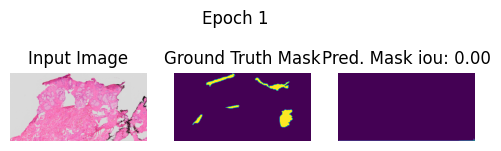

57/57 - 212s - loss: 1.1160 - accuracy: 0.8277 - dice_coef: 0.2885 - val_loss: 2453.9226 - val_accuracy: 0.8814 - val_dice_coef: 0.0015 - lr: 0.0010 - 212s/epoch - 4s/step
Epoch 2/10


KeyboardInterrupt: 

In [28]:
results = modelPipeline.train_model(model, train_ds, val_ds) # run for 1 epoch

In [ ]:
modelPipeline.save_model(model)